In [41]:
import scipy as sp
import numpy as np
import openmc.deplete
import matplotlib.pyplot as plt

chain = openmc.deplete.Chain.from_xml('chain_endfb71_pwr.xml')
results = openmc.deplete.Results("./depletion_results.h5")
V = 48710000.0 / 1e6
isotopes = ['Xe135','Pa233','Sm149']
sources = {}
for iso in isotopes:
    t, vals = results.get_atoms('1',iso)
    sources[iso] = sp.interpolate.CubicSpline(t, vals, extrapolate=True)
    
noble = ['Ru','Os','Rh','Ir','Pd','Pt','Ag','Au']
noble_metals = {metal :{'isos':[]} for metal in noble}
for nuc in chain.nuclide_dict.keys():
    for metal in noble:
        if metal in nuc:
            '''Add Logic for only stable isotopes'''
            noble_metals[metal]['isos'].append(nuc)
for metal, D in noble_metals.items():
    isotopes = D['isos']
    val = np.zeros(len(t))
    for iso in isotopes:
        t, vals = results.get_atoms('1',iso)
        val += vals
    sources[metal] = sp.interpolate.CubicSpline(t, val, extrapolate=True)

In [70]:
t = [5, 30, 60, 120]
for name, func in sources.items():
    vals = func(t)
    string = [str(np.format_float_scientific(val, precision=1)) + ' & ' for val in vals]
    string = name + ' & ' + ''.join(string)[:-3] +'\\\\'
    print(string)
    print('\\hline')

Xe135 & 5.1e+17 & 3.1e+18 & 6.4e+18 & 1.3e+19\\
\hline
Pa233 & 2.7e+17 & 1.0e+19 & 4.e+19 & 1.6e+20\\
\hline
Sm149 & 1.6e+10 & 1.3e+11 & 5.e+11 & 3.9e+12\\
\hline
Ru & 1.4e+17 & 1.7e+18 & 5.8e+18 & 2.1e+19\\
\hline
Os & -4.4e+01 & 8.6e+01 & -8.1e+00 & -2.3e+01\\
\hline
Rh & 4.1e+16 & 2.9e+17 & 6.4e+17 & 1.4e+18\\
\hline
Ir & 8.4e+00 & -1.5e+01 & -3.7e-04 & 4.3e+00\\
\hline
Pd & 7.0e+16 & 5.1e+17 & 1.2e+18 & 2.7e+18\\
\hline
Pt & -5.3e+00 & 4.3e+00 & 2.4e+00 & -4.4e+00\\
\hline
Ag & 3.e+16 & 2.e+17 & 4.4e+17 & 9.5e+17\\
\hline
Au & -9.6e-03 & 9.8e-03 & 9.1e-05 & -1.1e-01\\
\hline


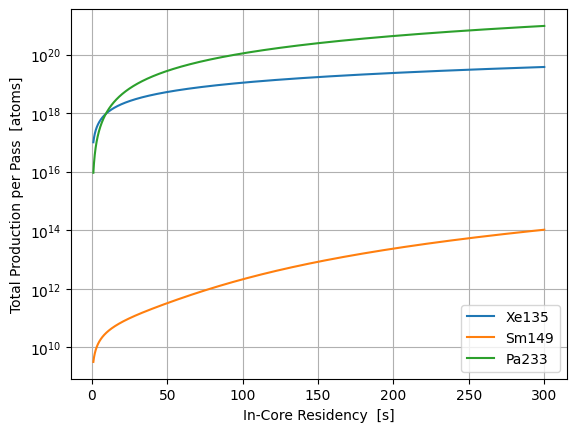

In [83]:
lis = ['Xe135','Sm149','Pa233']
t = np.linspace(1,300, 10000)
for nuc in lis:
    plt.semilogy(t, sources[nuc](t), label=nuc)
plt.grid()
plt.xlabel('In-Core Residency  [s]')
plt.ylabel('Total Production per Pass  [atoms]')
plt.legend()
plt.savefig('sourceplot.png', dpi=600)